In [49]:
# Core libraries and model APIs
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import collections

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.base import BaseEstimator, ClassifierMixin, clone

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Load and tidy the engineered feature sheet
ctg_path = Path("cardiotocography/CTG.xls")
assert ctg_path.exists(), f"Expected Excel file at {ctg_path.resolve()}"

def read_feature_sheet(path: Path, sheet=0):
    """Load the CTG feature sheet, using row 2 as headers and data from row 3 onward."""
    xls = pd.ExcelFile(path)
    sheet_name = xls.sheet_names[sheet] if isinstance(sheet, int) else sheet
    try:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
    except ValueError:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    return df

raw_features = read_feature_sheet(ctg_path, sheet=1)
raw_features.shape

(2129, 46)

In [3]:
# Clean columns, drop leakage, and ensure numerics
def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    cleaned = df.copy()
    cleaned.columns = [str(col).strip() for col in cleaned.columns]
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',
        'TENDENCY': 'Tendency'
    }
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})
    return cleaned

sheet2 = tidy_sheet(raw_features)
target_col = 'NSP'
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
feature_cols = [col for col in sheet2.columns if col not in label_leak_cols + [target_col]]
clean_df = (
    sheet2
    .drop(columns=label_leak_cols, errors='ignore')
    .dropna(axis=0, how='all')
    .drop_duplicates()
)

# Coerce numeric columns and drop rows without labels
numeric_cols = feature_cols
clean_df[numeric_cols] = clean_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
clean_df = clean_df.dropna(subset=[target_col]).copy()
clean_df[target_col] = clean_df[target_col].astype(int)

X = clean_df[numeric_cols]
y = clean_df[target_col]
X.shape, y.value_counts().sort_index()

((2115, 30),
 NSP
 1    1647
 2     293
 3     175
 Name: count, dtype: int64)

In [4]:
# Stratified train/test split and class weights
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
classes = np.unique(y_train)
class_weight_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weight_values))
sample_weight_train = compute_sample_weight(class_weight='balanced', y=y_train)

distribution = (
    pd.DataFrame({
        'Split': ['Train', 'Test'],
        'Size': [len(y_train), len(y_test)],
        'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],
        'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],
        'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]
    })
    .rename(columns=lambda c: c if c in {'Split', 'Size'} else f'{c} proportion')
)
distribution, class_weight_dict

(   Split  Size  Normal (1) proportion  Suspect (2) proportion  \
 0  Train  1480                   0.78                    0.14   
 1   Test   635                   0.78                    0.14   
 
    Pathologic (3) proportion  
 0                       0.08  
 1                       0.08  ,
 {np.int64(1): np.float64(0.4278693263949118),
  np.int64(2): np.float64(2.4065040650406506),
  np.int64(3): np.float64(4.043715846994536)})

In [79]:
# Shared evaluation helper edited with latency
results = []

def evaluate_model(name, estimator, X_train, y_train, X_test, y_test, fit_kwargs=None, display_report=False):
    fit_kwargs = fit_kwargs or {}
    fit_start = time.time()
    estimator.fit(X_train, y_train, **fit_kwargs)
    fit_time = time.time() - fit_start
    pred_start = time.time()
    y_pred = estimator.predict(X_test)
    pred_time = time.time() - pred_start
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append({'Model': name, 'Balanced Accuracy': bal_acc, 'F1 Macro': f1, 'Prediction Time': pred_time, 'Fit Time': fit_time})
    print(f"{name} — Balanced Accuracy: {bal_acc:.3f}, Macro F1: {f1:.3f}, Prediction Time: {pred_time:.4f}s, Fit Time: {fit_time:.4f}s")
    if display_report:
        print(classification_report(y_test, y_pred, digits=3))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=sorted(classes), normalize=None, cmap='Blues'
    )
    disp.ax_.set_title(f"{name} — Normalized Confusion Matrix")
    plt.show()
    print("Pred counts:", collections.Counter(y_pred))
    return estimator, y_pred

classes

array([1, 2, 3])

In [73]:
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, thresholds=None, reject_margin=None):
        self.base_estimator = base_estimator
        self.thresholds = thresholds or {}
        self.reject_margin = reject_margin
    
    def fit(self, X, y, **fit_params):
        self.estimator_ = clone(self.base_estimator)
        self.estimator_.fit(X, y, **fit_params)
        self.classes_ = np.array(self.estimator_.classes_)
        if 3 in self.classes_:
            self.cls3_idx = np.where(self.classes_ == 3)[0][0]
        else:
            self.cls3_idx = None
        if 2 in self.classes_:
            self.cls2_idx = np.where(self.classes_ == 2)[0][0]
        else:
            self.cls2_idx = None
        return self
    
    def predict(self, X):
        if not hasattr(self.estimator_, "predict_proba"):
            return self.estimator_.predict(X)
        probs = self.estimator_.predict_proba(X)
        preds_idx = np.argmax(probs, axis=1)
        if 3 in self.thresholds:
            thr = self.thresholds[3]
            override = probs[:, self.cls3_idx] >= thr
            preds_idx[override] = self.cls3_idx
        if self.reject_margin is not None and self.cls3_idx is not None and self.cls2_idx is not None:
            top2_idx = np.argsort(probs, axis=1)[:, -2:]
            top2_vals = np.take_along_axis(probs, top2_idx, axis=1)
            close = (top2_vals[:, 1] - top2_vals[:, 0]) < self.reject_margin
            cls3_in_top2 = np.any(top2_idx == self.cls3_idx, axis=1)
            to_reject = close & cls3_in_top2
            preds_idx[to_reject] = self.cls2_idx
        
        return self.classes_[preds_idx]
    
    def predict_proba(self, X):
        return self.estimator_.predict_proba(X)

Model: Decision Tree

Decision Tree — Balanced Accuracy: 0.867, Macro F1: 0.827, Prediction Time: 0.0010s, Fit Time: 0.0208s
              precision    recall  f1-score   support

           1      0.962     0.911     0.936       494
           2      0.663     0.784     0.719        88
           3      0.762     0.906     0.828        53

    accuracy                          0.893       635
   macro avg      0.796     0.867     0.827       635
weighted avg      0.904     0.893     0.896       635



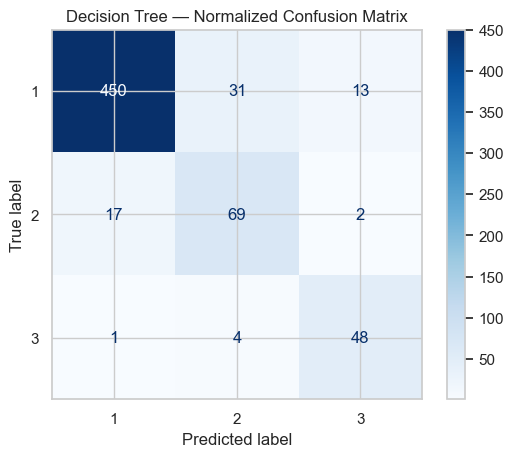

Pred counts: Counter({np.int64(1): 468, np.int64(2): 104, np.int64(3): 63})


In [83]:
tree_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('tree', DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=None,
        class_weight='balanced',
        random_state=42
    ))
])
_ = evaluate_model('Decision Tree', tree_pipeline, X_train, y_train, X_test, y_test, display_report=True)

Model Improved: Decision Tree

Decision Tree — Balanced Accuracy: 0.874, Macro F1: 0.837, Prediction Time: 0.0010s, Fit Time: 0.0245s
              precision    recall  f1-score   support

           1      0.962     0.911     0.936       494
           2      0.670     0.807     0.732        88
           3      0.787     0.906     0.842        53

    accuracy                          0.896       635
   macro avg      0.806     0.874     0.837       635
weighted avg      0.907     0.896     0.900       635



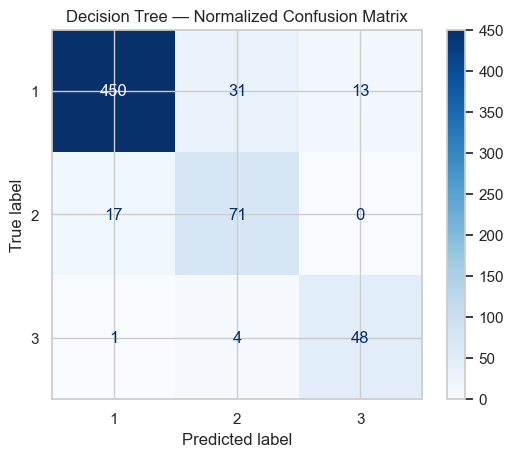

Pred counts: Counter({np.int64(1): 468, np.int64(2): 106, np.int64(3): 61})


In [85]:
tree_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('tree', ThresholdClassifier(
        base_estimator=DecisionTreeClassifier(
            criterion='entropy',
            min_samples_leaf=5,
            max_depth=None,
            class_weight='balanced',
            random_state=42
        ),
        thresholds={3:0.25},
        reject_margin=0.1
    ))
])
_ = evaluate_model('Decision Tree', tree_pipeline, X_train, y_train, X_test, y_test, display_report=True)

Model: Gradient Boosting

Gradient Boosting — Balanced Accuracy: 0.915, Macro F1: 0.934, Prediction Time: 0.0096s, Fit Time: 5.9550s
              precision    recall  f1-score   support

           1      0.968     0.992     0.980       494
           2      0.936     0.830     0.880        88
           3      0.961     0.925     0.942        53

    accuracy                          0.964       635
   macro avg      0.955     0.915     0.934       635
weighted avg      0.963     0.964     0.963       635



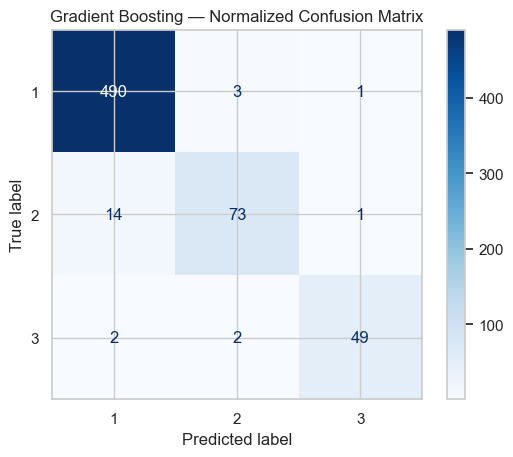

Pred counts: Counter({np.int64(1): 506, np.int64(2): 78, np.int64(3): 51})


In [80]:
gb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ))
])
gb_fit_kwargs = {'gb__sample_weight': sample_weight_train}
_ = evaluate_model('Gradient Boosting', gb_pipeline, X_train, y_train, X_test, y_test, fit_kwargs=gb_fit_kwargs, display_report=True)

Model Improved: Gradient Boosting

Gradient Boosting — Balanced Accuracy: 0.915, Macro F1: 0.932, Prediction Time: 0.0081s, Fit Time: 5.9120s
              precision    recall  f1-score   support

           1      0.968     0.990     0.979       494
           2      0.924     0.830     0.874        88
           3      0.961     0.925     0.942        53

    accuracy                          0.962       635
   macro avg      0.951     0.915     0.932       635
weighted avg      0.962     0.962     0.961       635



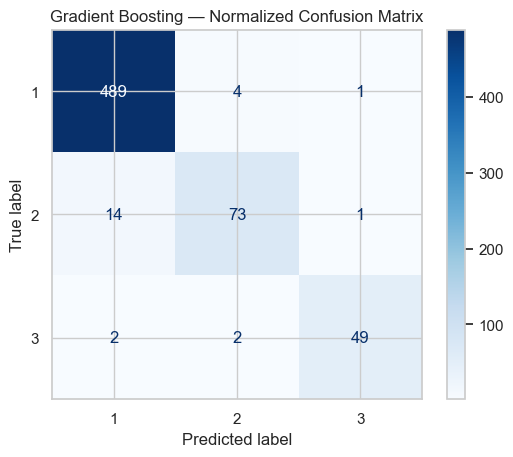

Pred counts: Counter({np.int64(1): 505, np.int64(2): 79, np.int64(3): 51})


In [86]:
gb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('gb', ThresholdClassifier(
        base_estimator=GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
        ),
        thresholds={3: 0.25},
        reject_margin=0.1
    ))
])
gb_fit_kwargs = {'gb__sample_weight': sample_weight_train}
_ = evaluate_model('Gradient Boosting', gb_pipeline, X_train, y_train,
                   X_test, y_test, fit_kwargs=gb_fit_kwargs, display_report=True)

In [38]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight={3:10}, max_iter=2000)
clf.fit(X_train, y_train)
print("clf.classes_:", clf.classes_)  

clf.classes_: [1 2 3]


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
